<div style="float:left">
    <h1 style="width:450px">Practical 6: Spatial Data</h1>
    <h2 style="width:450px">Getting to grips with Geo-Data using Geopandas</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Practical-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

## Preamble

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: It makes life a lot easier if you gather all of the library import commands and configuration information (here having to do with `matplotlib`) in the first exectuable code block in a notebook or script. That way it's easy for you for others to see what what it is necessary to have installed before getting started!.</div>

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## 1. Reading Geo-Data

I find GeoPackages to be by far the easiest way to distribute geo-data now: they are a single file (in a database-like format that supports multiple types of data), include the projection information by default, and QGIS can even embed information about rendering style! 

However, we're getting a bit ahead of ourselves; let's start by writing a function (it will be _similar_ to the `get_url` function in `dtools`) to download the file to our hard drive and save it there. That way we don't have to keep downloading it week after week. I've set up the basics, but you'll need to Google [download remote file python](https://www.google.com/search?q=python+download+a+remote+file&rlz=1C5CHFA_enGB917GB917&oq=python+download+a+remote+file). If you're not sure about what something in this function does, I'd suggest that you use `return` statements to short-circuit the processing and `print` statements to output the various variables that I derive (e.g. `print(os.path.split(url.path))` and then add `[-1]` to see what that gives you or `print(url)` to see what that is!).

#### Task 1.1: Add Comments to Function

I've used the Numpy-style comments here, but the Google-style also look good in this context. See overview of commenting styles [on DataCamp](https://www.datacamp.com/community/tutorials/docstrings-python).

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: Use this as an opportunity to improve your ability to read code and to learn through documentation.</div>

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")
        
        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
        
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

#### Task 1.2: Read Remote Geo-Data

Use the function above to download and cache the GeoPackage files found [on GitHub](https://github.com/jreades/i2p/tree/master/data/src) for Boroughs, Water, and Greenspace, then pass the output of these to GeoPandas. If you have been having trouble downloading files from GitHub, then use the understanding of the function developed above to download the file manually and place it where this function expects to find it!

In [4]:
ddir  = os.path.join('data','geo') # destination directory (in case it is not found this directory is created)
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


#### Task 1.3: Check the Projection

Check the projection of each GeoDataFrame using a for loop and the `crs` attribute.

In [8]:
for gpkg in [boros,water,green]:
    print(gpkg.crs)

epsg:27700
epsg:27700
epsg:27700


You should see that all three are in the [EPSG:27700 CRS](https://epsg.io/27700) which is a common one for analysis using GB data.

#### Task 1.4: Check the Data

We'll see how you control figure-making more effectively later, but for now let's just see what they look like using plot:

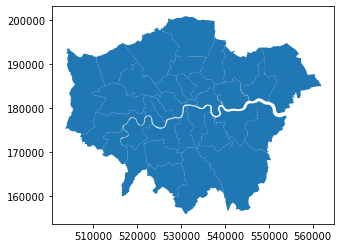

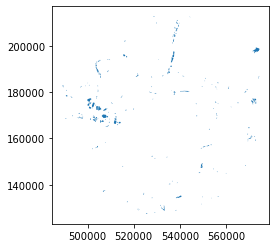

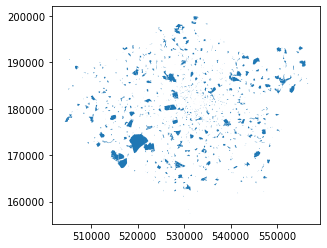

In [11]:
for gpkg in [boros,water,green]:
    gpkg.plot()

## 2. An Introduction to Mapping

These files all contain polygons, and the adjustments for points are different, but it's worth seeing how you can tweak these before we start combining them. Behind the scenes, GeoPandas is using `matplotlib` to render the map, so let's play with the colours to get the _start_ of something map-like. 

**I'd suggest the following colour scheme** (though anything you like is fine so long as you manipulate the colours):

- The boroughs can have red edges and white fill with a thick edge.
- The water should have no edges and XKCD Lightblue fill.
- The greenspace should have edges and faces specified using different alpha blending levels.

You will want to look both at [how to make maps in GeoPandas](https://geopandas.org/mapping.html) and  at the different ways to [specify colours in Matplotlib](https://matplotlib.org/3.1.1/tutorials/colors/colors.html#specifying-colors). For the greenspace map you are looking for information about tuples... which can have three or four elements.

#### Task 2.1: Adjust Borough Display

By way of a hint, matplotlib uses `edgecolor` and `facecolor` for controlling 'patches' (which is what polygons are considered), but the thicker-than-default line-width is specified differently (you'll need to look this up). So the intention is:
1. Thick red borough borders, and 
2. White fill colour.

Just to drive home how different this is from R, you can find the answer to question 1 [on the page for bar plots](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.bar.html).

<AxesSubplot:>

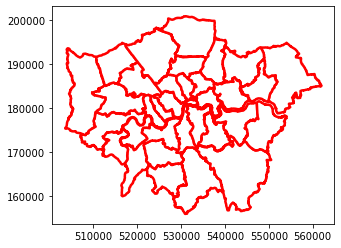

In [12]:
boros.plot(edgecolor='red', facecolor='white', linewidth=2.5)

#### Task 2.2: Adjust Water Display

The process is the same as above, but I'd like you to work out how to specify:
1. _No_ color for an edge, and 
2. An XKCD color for the face.

<AxesSubplot:>

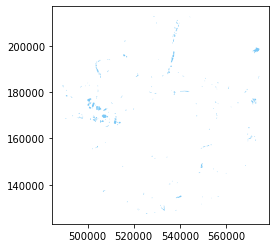

In [15]:
water.plot(edgecolor='none', facecolor='xkcd:lightblue')

#### Task 2.3: Adjust Greenspace Display

The process is _also_ the same as above, but I'd like you to work out how to specify colours and transparency using RGBA (red-green-blue-alpha) tuples. So we're looking for:
1. No edge color.
2. A partially transparent green specified as a tuple.

<AxesSubplot:>

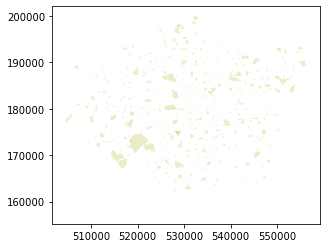

In [16]:
green.plot(edgecolor='none', facecolor=(0.7, 0.7, 0.14, 0.25))

#### Task 2.4 Combining Layers

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: R and Python take <i>very</i> different approaches to plotting. Do <i>not</i> think of Python's output as being 'maps' in the GIS sense, they are composed of 'patches' of color on abstract 'axes' that can use any arbitrary coordinate space. So colours are 'really' triplet (or quadruplet if you have alpha-blending transparency) values in the range 0.0-1.0. Annotations are then added in similarly abstract fashion.</div>

Now that we've got our layers looking roughly how we want them, it's time to combine them. This is also reliant on `matplotlib` and basically involves plotting items to _shared axes_ which is done by passing in `ax=<axis object>` to each `plot(...)`. By convention, if you only have a single figure (e.g. a single map) then you create an axis object and name it `ax` so you will see a lot of `ax=ax` code in graphing libraries, but `=ax` is just saying 'assign to the axis object that I created'.

Since the axes are how you control what is shown, see if you can find out by Googling how to set the x- and y-limits on the map so that it shows only London and trims out the much larger area of water that is outside of the Greater London Authority. **As a rough guideline, this has the Easting range 501,000 to 563,000, and the Northing range 155,000 to 202,000.**

You can set these limits before or after you start adding layers to the 'map', but it's probably easier conceptually to add them after with the idea of 'zooming in' on the features of interest. It's also easier to debug since you can start by seeing if you can plot the elements at all, and _then_ add the limits to zoom.

**So the steps are:**
1. Write the code to plot every image on the same set of axes (I've given you something to get started).
2. Google how to set the limits of the map and then use the ranges I've offered above.
3. Work out how to change the width of the edges for the boroughs layer. 
4. Save it somewhere local so that you could, say, load it into a Markdown file!

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: this is a first pass at a map, over the next few weeks we'll see how to add things like axis labels and titles to make it more 'map-like'. We don't have quite the built-in functionality of `ggplot` alas, but Python is advancing very quickly in this area. There is even <a href="https://github.com/yhat/ggpy">an implementation of ggplot in Python</a>, but it's functionality is more limited. In fact, there's <a href="https://github.com/has2k1/plotnine">more than one</a>...</div>

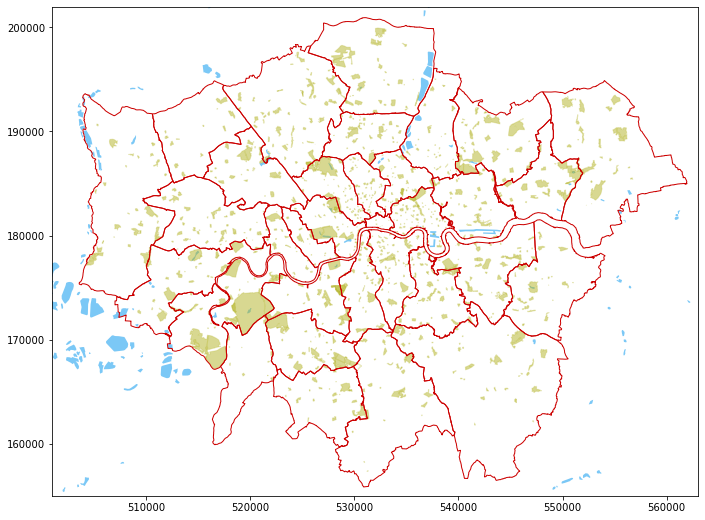

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot all three to the same axes
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14, 0.5), ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 1), facecolor='none', linewidth=1, ax=ax)

# Set the limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)

plt.savefig(os.path.join('img','Map-First_Pass.png'))

You may wish for a different look, but here's one version of the output:

![](https://github.com/jreades/i2p/raw/master/practicals/img/Map-First_Pass.png)

## 3. 'Creating' Geo-Data

Of course, you will also often encounter geo-data that is not yet 'geographically enabled'; the two most frequent contexts for this are:

1. The data represents points and is provided with latitude and longitude (or similar) as separate columns in a non-geographic data set.
2. The data represents polygons but is provided _separately_ from the polygons themselves and so cannot be shown on a map without being 'joined' to the geography first.

We'll tackle each of these eventually, but for now we're going to focus on the first option.

#### Task 3.1: CSV to Pandas

Let's re-use our `cache_data` function to download and save the full InsideAirbnb data set. Again, if you have trouble with downloading from GitHub via code, use your understanding of the function to work out where to save your own copy of this file so that the function works as expected.

In [3]:
ddir  = os.path.join('data','raw') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

# pdf == pandas dataframe
pdf = pd.read_csv( cache_data(spath+'2020-08-24-listings.csv.gz?raw=true', ddir),
    compression='gzip', low_memory=False)

NameError: name 'os' is not defined

In [23]:
# Free up memory (we're going to reload below)
del(pdf)

#### Task 3.2: Subsetting and Tidying Data Set

Now that we've downloaded the large file, let's subset only what we need for the purposes of this practical as it will make things run a _lot_ faster.

In [2]:
cols = ['id','listing_url','price','latitude','longitude',
        'host_id','host_since','property_type','room_type',
        'accommodates','beds','bathrooms_text']
pdf  = pd.read_csv( cache_data(spath+'2020-08-24-listings.csv.gz?raw=true', ddir),
        compression='gzip', low_memory=False, usecols=cols )

print(f"pdf now contains {pdf.shape[0]} rows.")
pdf.info()

NameError: name 'pd' is not defined

Your pandas data frame should contain 74,188 rows and 12 columns.

Convert the price to a float

In [1]:
pdf['price'].head()

NameError: name 'pdf' is not defined

In [76]:
# replace $ sign and commas
pdf['price'] = pdf.price.str.replace('$','').str.replace(',','').astype('float')

/tmp/ipykernel_86/2592575443.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pdf['price'] = pdf.price.str.replace('$','').str.replace(',','').astype('float')


Drop the **rows** where the `id` is null:

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: The `axis` for this is 0. After that, your pandas data frame should contain 74,186 rows.</div>

In [77]:
pdf.drop(pdf[pdf.id.isna()].index.values, axis=0, inplace=True)
print(f"pdf now contains {pdf.shape[0]} rows.")

pdf now contains 74186 rows.


Drop the **rows** where the geo-data is likely to be problematic:

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: This will follow the same approach as dropping Null ids. After that, your pandas data frame should contain 74,184 rows.</div>

In [78]:
# geo-data are columns 'latitude' and 'longitude' 
pdf.drop(pdf[pdf.latitude.isna()].index.values, axis=0, inplace=True)
pdf.drop(pdf[pdf.longitude.isna()].index.values, axis=0, inplace=True)
print(f"pdf now contains {pdf.shape[0]} rows.")

pdf now contains 74184 rows.


<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: <i>Not</i> doing the two steps above <a href="https://github.com/pygeos/pygeos/issues/231">led me to uncover a bug in PyGEOS</a> as I prepared your tutorial!</div>

#### Task 3.3: Checking Lat/Long

Before we mindlessly convert to something map-able it might make sense to sanity-check the data that's left as we _already_ know that there were some NaN values in the lat/long coordinates. In GeoPandas we have a `total_bounds` method that gives us the bounding box for a GeoSeries, but how would we do that in Pandas?

In [79]:
print(f"The bottom-left corner is {pdf.longitude.min()}, {pdf.latitude.min()}")
print(f"The top-right corner is {pdf.longitude.max()}, {pdf.latitude.max()}")

The bottom-left corner is -0.49625, 51.29479
The top-right corner is 0.2845, 51.68169


Your answer should be:
```
The bottom-left corner is -0.49625, 51.29479
The top-right corner is 0.2845, 51.68169
```

#### Task 3.4: Embedding Web Maps

This is more for the sake of demonstrating Python's features than because it's part of my workflow, but what the heck, let's do it! We will create and embed a zoomable web map in the notebook; to do _that_ we need to:

1. Calculate the bounds of the map using the min/max x and y coordinates above.
2. Calculate the centroid of the map from the bounds.
3. Set an appropriate zoom level.

If your work is going well, perhaps you may also want to experiment with [different basemaps](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html).

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: You can't use <tt>round</tt> here because it it could round up or down depending on what's closest and, consequently, cut off data on your map. So you'll have to look for two <i>other</i> functions that do this predictably (e.g. always rounding down, even if the value is 4.999999). However, those functions don't handle decimals like <tt>round</tt> does, so you need to think about how you could turn a number like 4.99 into a number that those functions <i>can</i> work with and then turn it <i>back</i> into the decimal...</div>

In [80]:
# eg. check help("math")
from math import floor, ceil

# Calculate min and max to two decimal points
xmin = floor(pdf.longitude.min()*100)/100
xmax = ceil(pdf.longitude.max()*100)/100
ymin = floor(pdf.latitude.min()*100)/100
ymax = ceil(pdf.latitude.max()*100)/100

print(xmin, xmax, ymin, ymax)

# Calculate the centre of the map
yctr = ymin+(ymax-ymin)/2
xctr = xmin+(xmax-xmin)/2

print(xctr, yctr)

-0.5 0.29 51.29 51.69
-0.10499999999999998 51.489999999999995


You should end up with `-0.5 0.29 51.29 51.69` for `print(xmin, xmax, ymin, ymax)`, and `51.4899999...` and `-0.109999...` for `yctr` and `xctr`.

If you've managed the calculations above, then this code should simply run!

In [81]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, projections

# Note the basemap can be easily changed (eg. http://leaflet-extras.github.io/leaflet-providers/preview/index.html)
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

m = Map(layers=(watercolor, ), center=(yctr, xctr), zoom=8)

rectangle = Rectangle(bounds=( (ymin, xmin), (ymax, xmax) ),
    crs=projections.EPSG4326
)

m.add_layer(rectangle)

m

Map(center=[51.489999999999995, -0.10499999999999998], controls=(ZoomControl(options=['position', 'zoom_in_tex…

Your map should look like this:

![](https://github.com/jreades/i2p/raw/master/practicals/img/Stamen.png)

#### Task 3.5: Lat/Long to GeoSeries

Right, we're finally there! We need to convert our coordinates into some kind of geo-data. GeoPandas offers two ways to do this: the original way using `zip` and a new utility method called `points_from_xy`. Here's the old way:
```python
from shapely.geometry import Point
gdf = gpd.GeoDataFrame(df, 
                geometry=[Point(x,y) for x, y in zip(df.Longitude,df.Latitude)])
```
Note, however, that this did not automatically set a projection, unlike the new approach with the helper method:

In [54]:
gdf = gpd.GeoDataFrame(pdf, 
      geometry=gpd.points_from_xy(pdf['longitude'], pdf['latitude'], crs='epsg:4326'))

In [83]:
print(type(gdf))
print(type(gdf.geometry))
print(gdf.geometry.iloc[1]) # Print out the object's contents
gdf.geometry.iloc[1] # The object knows how to print itself as a point
print(f"gdf contains {gdf.shape[0]} rows.")

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
POINT (531005.9675899239 187150.8429408408)
gdf contains 74178 rows.


#### Task 3.6: Saving Geo-Data Locally

Since there are _many_ formats in which to save geo-data, rather than have multiple `to_format_x` methods, GeoPandas has _one_ for local files (`to_file`) and requires you to specify a `driver` as part of the process. For educational purposes, try running the code below _without_ specifying a driver and then have a look at what has happened on your hard drive... then delete that output and re-run the code _with_ an appropriate driver. Google this if necessary.

In [56]:
boros.to_file('test.gpkg') # This won't do what we want

Save the InsideAirbnb GeoDataFrame to the 'geo' directory:

In [57]:
boros.to_file('test.gpkg', driver='GPKG')

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: It's worth comparing the output of a point (above) with the output of a polygon or multi-polygon below. You may well come across data in formats resembling both of these in real data sets but they <i>can</i> be read as well.</div>

MULTIPOLYGON (((535009.2 159504.7, 535005.5 159502, 535002.9 159500.1, 535000.1 159503.2, 535000 159503.2, 534747.8 159517.8, 534588 159522.1, 534512.3 159780.5, 534474.8 159760.8, 534398.8 159726.7, 534391.9 159723.3, 534378.9 159712.4, 534345.1 159702.8, 534314.3 159691.8, 534292.7 159683.9, 534253.1 159666.6, 534229.4 159657.9, 534207.5 159654.6, 534160.5 159651.5, 534159.7 159637.1, 534109.5 ...


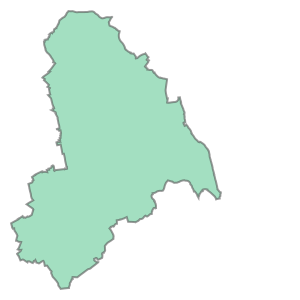

In [58]:
print(str(boros.geometry.iloc[1])[:399] + "...") # Object to string then print out first 399 characters
boros.geometry.iloc[1] # So this is a multi-polygon boundary

So each element of this Series has text indicating the type of shape the geometry applies to (e.g. _POLYGON_) followed by a bunch of numbers. These numbers are truncated here just to make things a little more legible.

## 4. Dealing with Projections and Data

#### Task 4.1: Reprojection

Let's start by looking at our InsideAirbnb data in its original projection.

epsg:4326
[-0.49625 51.29479  0.2845  51.68169]


<AxesSubplot:>

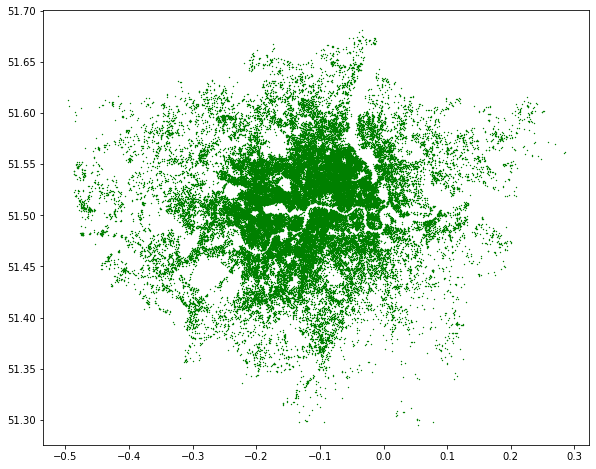

In [59]:
print(gdf.geometry.crs)
print(gdf.total_bounds)
gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.25)

Reproject this into the OSGB1936/BNG CRS and plot again using same code as above:

epsg:27700
[504217.92646779 157034.61418108 558451.35517932 199932.45808543]


<AxesSubplot:>

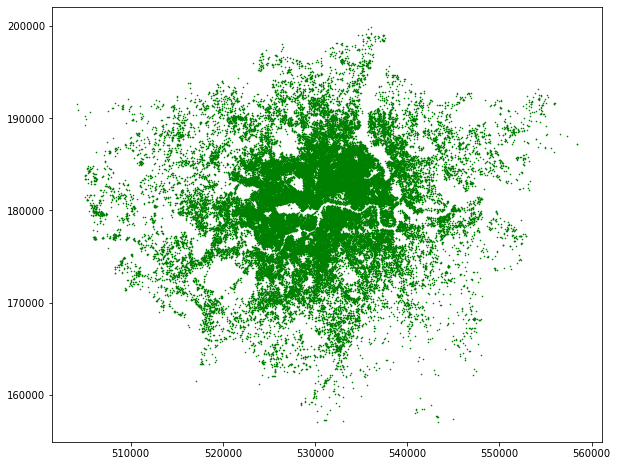

In [62]:
gdf = gdf.to_crs("epsg:27700")
print(gdf.geometry.crs)
print(gdf.total_bounds)
gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.5)

#### Task 4.2: Choropleth Mapping

In its original form, the pricing data will not reveal much of interest because of the range of the data. However, if we take the log of the price data then we may get something of a useful choropleth. That said, if you intend to make use of the pricing data I would suggest that you do some exploration of the outliers, especially the upper ones!

In [69]:
# :,.[n]f gives 'n' decimal numbers
print(f"The range of price is ${gdf.price.min():,.2f} to ${gdf.price.max():,.2f}")
print(f"The mean and median of the price are ${gdf.price.mean():,.2f} and ${gdf.price.median():,.2f}")

The range of price is $0.00 to $18,638.00
The mean and median of the price are $118.78 and $79.00


Notice the neat little commad-separated thousands in there? That's fairly easy to do in English, but to use a thousands separator common to another language you would need to do something [a little more tricky](https://stackoverflow.com/questions/13082620/how-can-i-print-a-float-with-thousands-separators). 

Anyway, I'd like you to:
1. Take the natural-log of the price and assign to a new Series called `lnprice`.
2. Work out what the error means.
3. Work out how to fix the error based on what we did above.
4. Work out how many rows were affected.
5. Report on the new min/max values.

In [74]:
print(f"gdf has {gdf.shape[0]:,.0f} rows.")
gdf.drop(gdf[gdf.price==0].index, axis=0, inplace=True) # no values price==0, this data set might not have errors in price
gdf['lnprice'] = np.log(gdf.price) 
print(f"gdf has {gdf.shape[0]:,.0f} rows.")
print(f"The range of ln(price) is {gdf.lnprice.min():,.2f} to {gdf.lnprice.max():,.2f}")

gdf has 74,178 rows.
gdf has 74,178 rows.
The range of ln(price) is 1.95 to 9.83


You should get that the ln(price) range is 1.95 to 9.83 and the number of rows is 74,178.

Now plot the ln(price) as a choropleth using:
1. A figure size of 12 x 8
2. A marker size of 0.25
3. The Viridis colourmap
4. A legend
5. A legend label of 'Natural Log of Price per Night ($)'

I'd suggest [referring to the documentation](https://geopandas.org/mapping.html).

<AxesSubplot:>

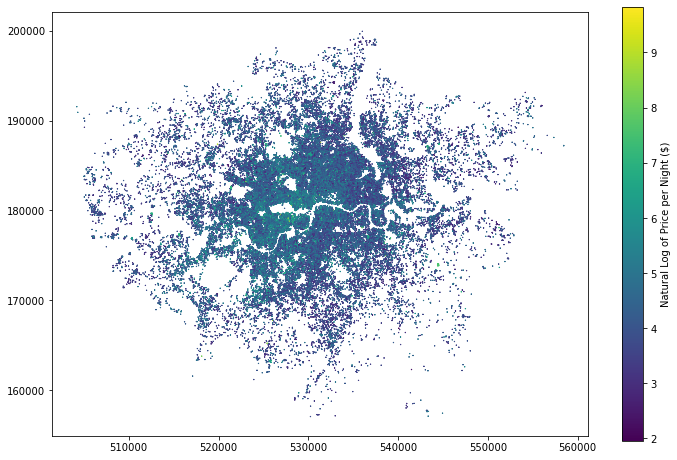

In [84]:
gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'})

Your map should look something like this:
    
![](https://github.com/jreades/i2p/raw/master/practicals/img/Airbnb-lnprice.png)

#### Task 4.3: Zooming In/Out

That's a little hard to see, let's try zooming in on Central London! Very roughly, let's call that an Easting range of 525,000 to 535,000 and a Northing range of 178,000 to 185,000.

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: You will need to remember that <tt>GeoDataFrame.plot()</tt> returns an axis object.</div>

(178000.0, 185000.0)

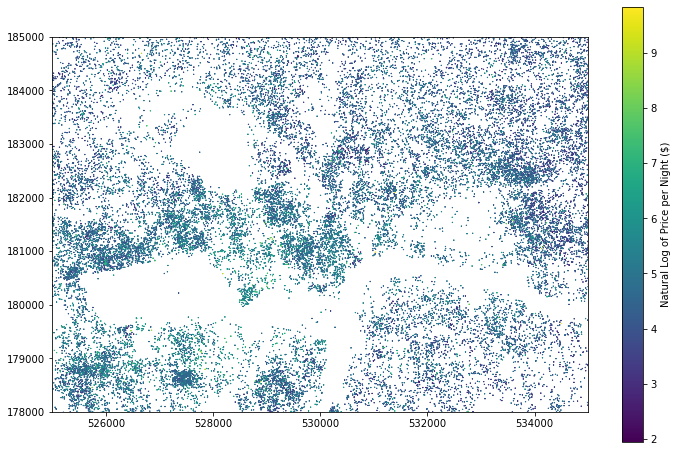

In [85]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'})
ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000])

![](https://github.com/jreades/i2p/raw/master/practicals/img/Airbnb-lnprice-zoom.png)

That's a little better, but ideally we'd do a lot more thinking about outliers... 

#### Task 4.4: Recall!

Remeber that GeoPandas _inherits_ functionality from Pandas. First, let's check what data type `gdf` is using the [`isinstance`](https://www.w3schools.com/python/ref_func_isinstance.asp) function:

In [86]:
if isinstance(gdf, gpd.GeoDataFrame): # Is gdf a GeoDataFrame object?
    print("\tI'm a geopandas data frame!")

if isinstance(gdf, pd.DataFrame): # Is gdf *also* a DataFrame object?
    print("\tI'm also a pandas data frame!")

	I'm a geopandas data frame!
	I'm also a pandas data frame!


In which case we can...

<AxesSubplot:>

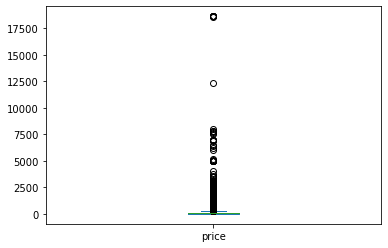

In [87]:
gdf.price.plot.box()

<AxesSubplot:>

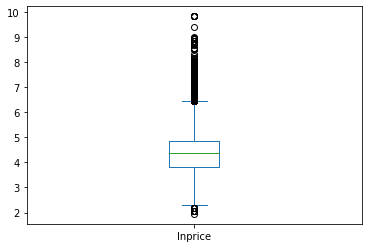

In [88]:
gdf.lnprice.plot.box()

#### Task 4.5: Changing the Classification Scheme

Let's give this one last try using a different classification scheme... such as Fisher-Jenks!

(178000.0, 185000.0)

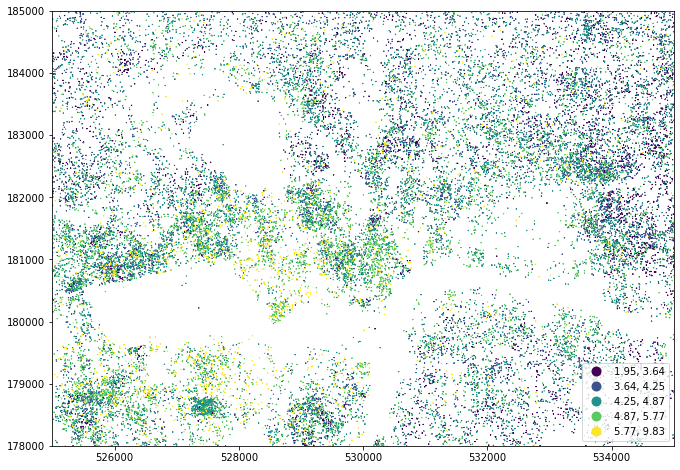

In [105]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True) # Note that the legend label had to go -- there are other ways to add it

ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000])
# test other 
# colormaps cmap (eg. https://matplotlib.org/stable/api/pyplot_summary.html#matplotlib.pyplot.colormaps)
# scheme (eg. quantile, equal_interval) 
# and number of k

#### Task 4.6: Bringing it All Together

And just to give a bit of a show of how we can put it all together:

In [92]:
import legendgram
help(legendgram.legendgram)

Help on function legendgram in module legendgram.legendgram:

legendgram(f, ax, y, breaks, pal, bins=50, clip=None, loc='lower left', legend_size=(0.27, 0.2), frameon=False, tick_params=None)
    Add a histogram in a choropleth with colors aligned with map
    ...
    
    Arguments
    ---------
    f           : Figure
    ax          : AxesSubplot
    y           : ndarray/Series
                  Values to map
    breaks      : list
                  Sequence with breaks for each class (i.e. boundary values
                  for colors)
    pal         : palettable colormap
    clip        : tuple
                  [Optional. Default=None] If a tuple, clips the X
                  axis of the histogram to the bounds provided.
    loc         :   string or int
                    valid legend location like that used in matplotlib.pyplot.legend
    legend_size : tuple
                  tuple of floats between 0 and 1 describing the (width,height)
                  of the legend relat

In [3]:
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

q = mc.Quantiles(gdf.price.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdf.plot(column='price', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

ax.set_xlim([525000,540000])
ax.set_ylim([176000,186000])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Price Per Night', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Price Per Night")  #set the legend title

legendgram(f, ax, 
            gdf.price, q.bins, bins=round(gdf.price.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig('ppn.png', dpi=150)

NameError: name 'gdf' is not defined

You should have something like this:
    
![](https://github.com/jreades/i2p/raw/master/practicals/img/Airbnb-price-all.png)

I'll be honest, I do find ggplot easier for making good-quality; this _is_ more customisable overall, but it's also much more 'magical' in the sense of 'search for `matplotlib` examples that do what you want then copy+paste them and tweak' being the main way that most people get things working how they want.

Scalebars are awkward, though I did discover that there's now a library that can help with this [on GitHub](https://github.com/ppinard/matplotlib-scalebar). Unfortunately, as this is not part of the default image, while you _can_ install it on a per-session basis you will lose it each time you restart Docker.

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: You can find a lot of _possible_ solutions in <a href="https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot">this Stackoverflow thread</a> that <i>should</i> work without needing to install new libraries but I've not had a chance to test them each individually. You would undoubtedly want to put this in an external package and import it when needed rather than paste this code into every file. But you might find it easier to <i>test</i> the solutions by pasting. If you're looking for glory (and my gratitude) then working out which of these is most generalisable (i.e. would work with both lat/long <i>and</i> OSGB coordinates) would be quite the challenge!</div>

### Getting More Help/Applications

A great resource for more help and more examples is Dani Arribas-Bel's _Geographic Data Science_ module: he has put all of his [module practicals online](http://darribas.org/gds17/) (as we have too), and you might find that something that he does makes more sense to you than what we've done... check it out!

## Credits!

#### Contributors:
The following individuals have contributed to these teaching materials: Jon Reades (jonathan.reades@kcl.ac.uk), James Millington (james.millington@kcl.ac.uk)

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).

#### Acknowledgements:
Supported by the [Royal Geographical Society](https://www.rgs.org/HomePage.htm) (with the Institute of British Geographers) with a Ray Y Gildea Jr Award.

#### Potential Dependencies:
This notebook may depend on the following libraries: pandas, matplotlib, seaborn